# Intermediate Project - SAAS Career Exploration - Part 3

This will be the last part of this project! Since this is a bit longer than the previous parts, it will be due in **two weeks** instead of one, so the due date will be **March 22**.

In [13]:
# Setup code
import seaborn as sns #; sns.set()
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown

general = pd.read_csv("2016-us-election/county_facts.csv")
column_dict_df = pd.read_csv("2016-us-election/county_facts_dictionary.csv")
primaries = pd.read_csv("2016-us-election/primary_results.csv")

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
# Credit to https://gist.github.com/rogerallen/1583593

# Turn the county_facts_dictionary.csv file into a dictionary
column_dict = column_dict_df.set_index("column_name").to_dict()['description']

# Use that dictionary to rename the columns of general
general.columns = general.columns.to_series().map(lambda x: column_dict.get(x,x))

# Extract the rows corresponding to states from general (note that these are the rows with NaN in the 
# state_abbreviation column, minus the first row which is the whole US)
states = general[general['state_abbreviation'].isnull()][1:].reset_index(drop=True)

# Attach the state abbreviations to the states dataframe
states["state_abbreviation"] = general["state_abbreviation"].unique()[1:]

# Extract the rows corresponding to counties from general
counties = general[~general['state_abbreviation'].isnull()].reset_index(drop=True)

# Create the pivot table from last time
pivot_table = pd.pivot_table(primaries,index=["state","county"],columns="candidate",values="fraction_votes")
pivot_table.reset_index(inplace = True)

# Join the two dataframes together
pivot_table["state_abbreviation"] = pivot_table["state"].map(us_state_abbrev)
pivot_table["state_county"] = pivot_table["state_abbreviation"] + " " + pivot_table['county'] + ' County'
counties["state_county"] = counties["state_abbreviation"] + " " + counties["area_name"]

df = pd.merge(pivot_table,counties,on="state_county")
df.head()

,state,county,No Preference,Uncommitted,Ben Carson,Bernie Sanders,Carly Fiorina,Chris Christie,Donald Trump,Hillary Clinton,...,"Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($1,000)","Building permits, 2014","Land area in square miles, 2010","Population per square mile, 2010"
0,Alabama,Autauga,NaN,NaN,0.146,0.182,NaN,NaN,0.445,0.800,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
1,Alabama,Baldwin,NaN,NaN,0.084,0.329,NaN,NaN,0.469,0.647,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
2,Alabama,Barbour,NaN,NaN,0.122,0.078,NaN,NaN,0.501,0.906,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0
3,Alabama,Bibb,NaN,NaN,0.099,0.197,NaN,NaN,0.494,0.755,...,0.0,0.0,0,0,124707,5804,10757,19,622.58,36.8
4,Alabama,Blount,NaN,NaN,0.100,0.386,NaN,NaN,0.487,0.551,...,0.0,23.2,341544,0,319700,5622,20941,3,644.78,88.9


## 1. Linear models

In this last part, we are going to create linear models to predict various parts of your data. First, pick a quantititative variable $y$ which you would like to predict and another quantitative variable $x$ which you think will be predictive of $y$. 

### 1.1. Preliminary plotting

Before we actually fit a linear model, we should make sure that there is a somewhat linear relationship between our two variables. <span style="color:blue"> Plot a scatterplot of $x$ and $y$ and verify that the relationship looks somewhat linear. </span> If it looks like there is some relationship but it is nonlinear, you can try [straightening the data](https://rstudio-pubs-static.s3.amazonaws.com/199830_f5e58983719e4ffc8d60fd277f9352e5.html) by applying transformations such as $x^2$ or $\sqrt{x}$ to the axes; alternatively, you can just try to find a different $x$ or $y$ variable.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


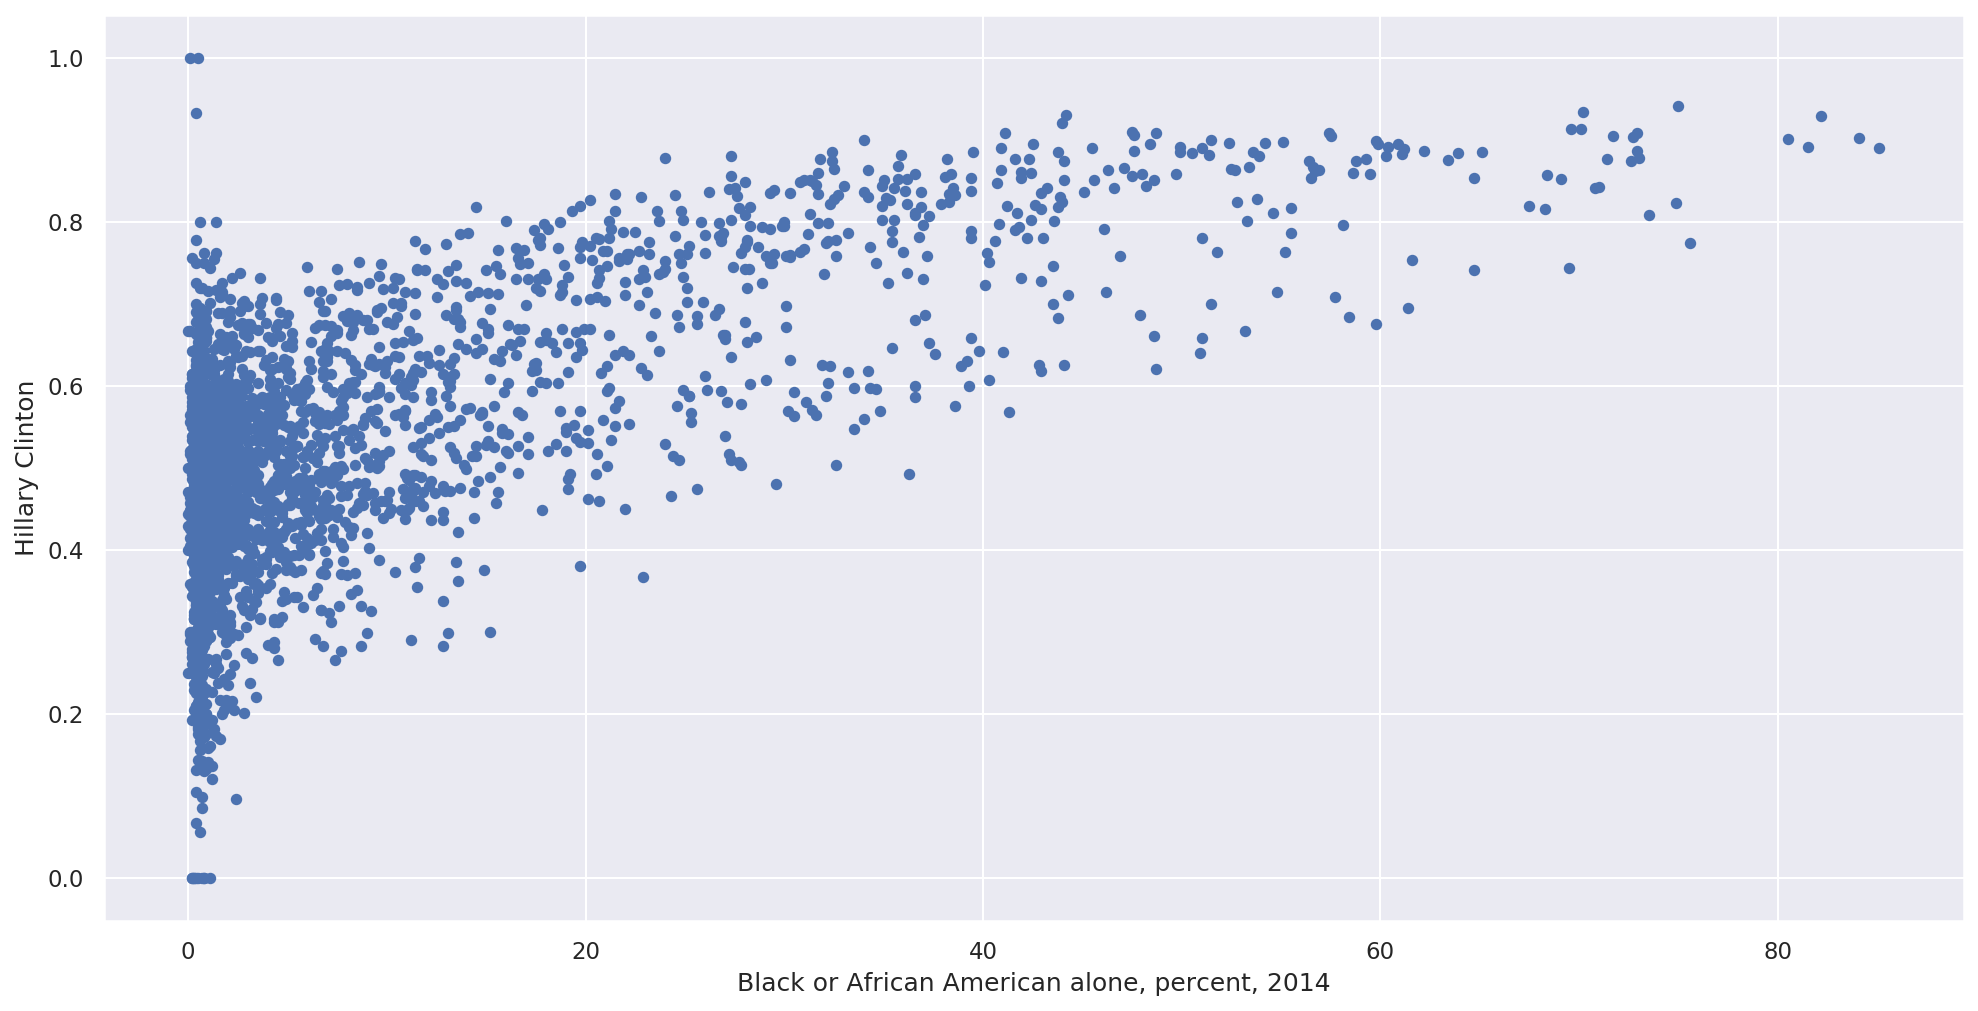

In [14]:
# YOUR CODE HERE
df.plot.scatter("Black or African American alone, percent, 2014", "Hillary Clinton")


### 1.2. Creating the model

<span style="color:blue">Next, use sklearn to fit a linear model of $y$ on $x$. </span> Remember that in order to do this, you'll need to first create variables `X` and `Y` to feed into the `linear_model.fit` function.

In [15]:
# YOUR CODE HERE
X = df[["Black or African American alone, percent, 2014"]]
Y = df[["Hillary Clinton"]]
model = LinearRegression()
model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now that we have our linear model, <span style="color:blue">add the line of best fit to the scatterplot from above</span>. If you want some additional practice, try doing this from scratch instead of copying the function from the lecture notes.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


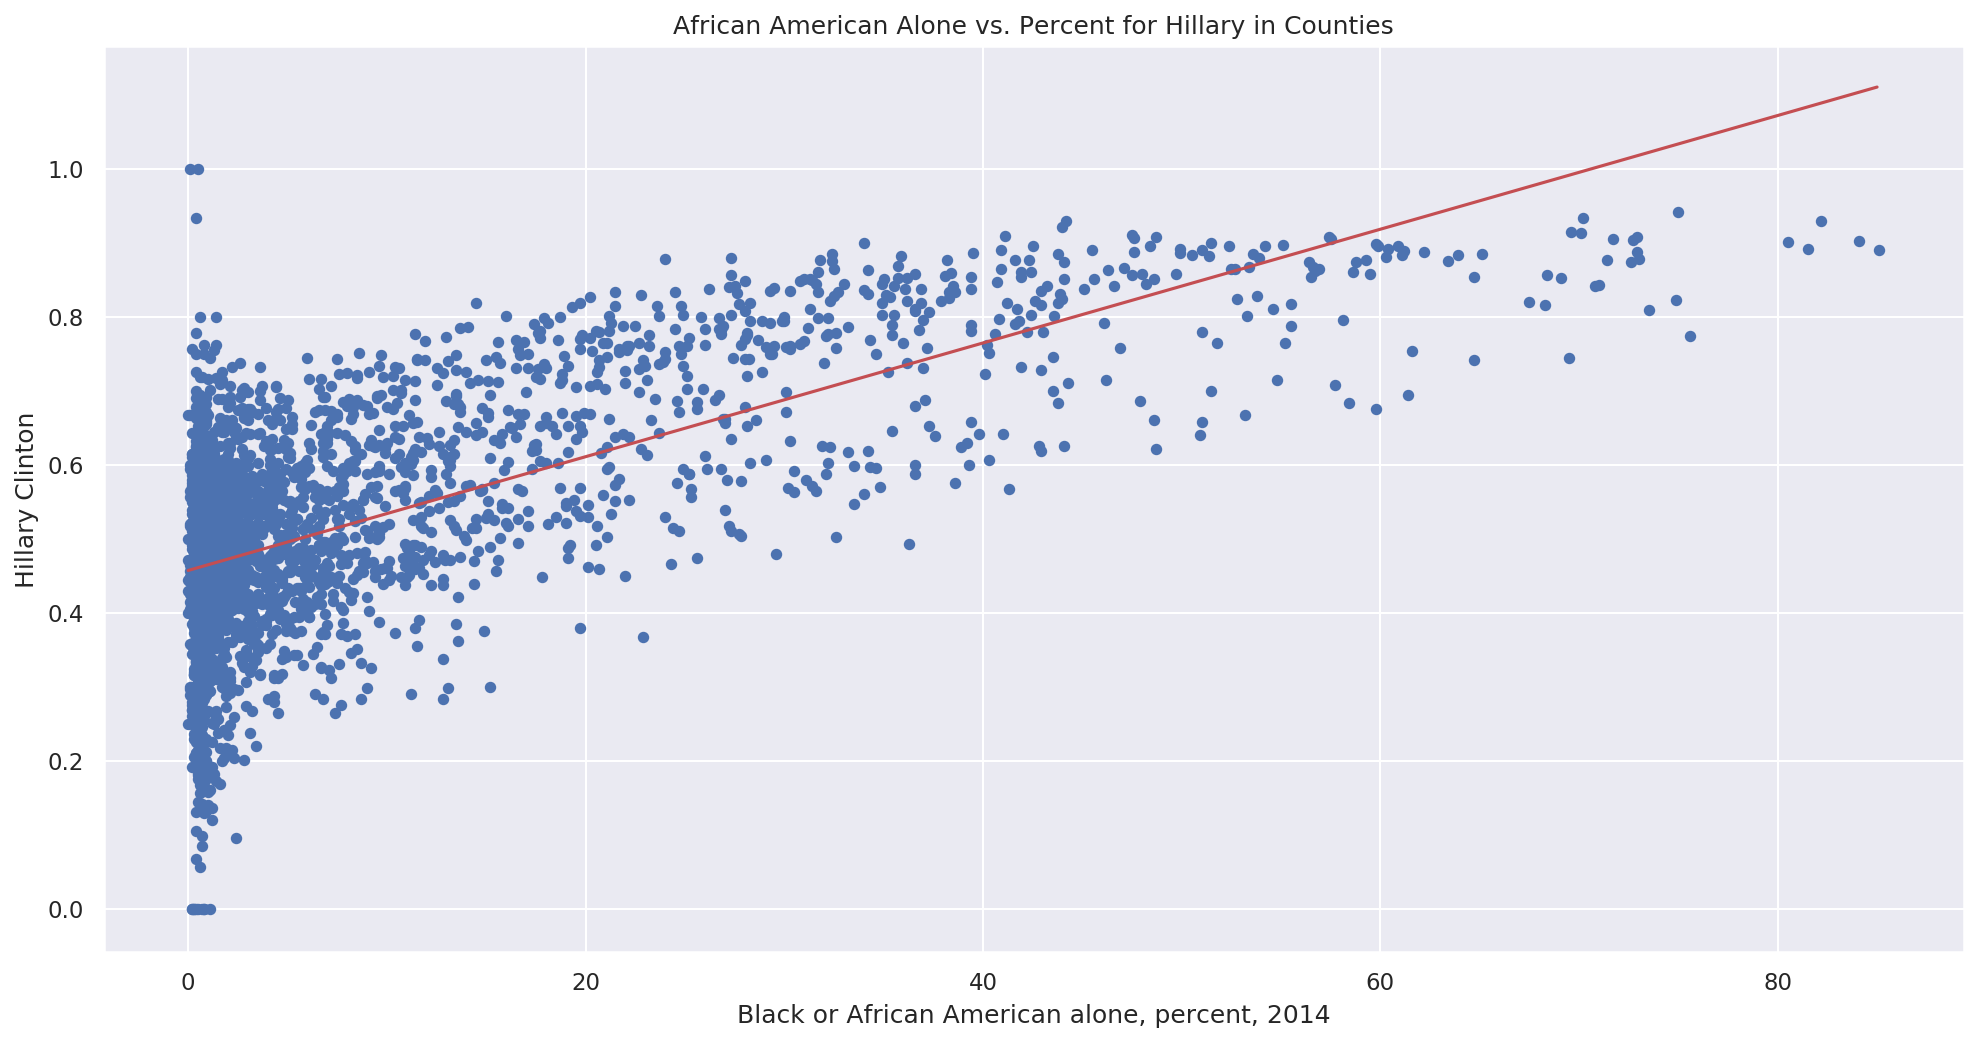

In [18]:
# YOUR CODE HERE
x = np.arange(max(df["Black or African American alone, percent, 2014"])).reshape(-1, 1)
y = model.predict(x)
df.plot.scatter("Black or African American alone, percent, 2014", "Hillary Clinton")
plt.title("African American Alone vs. Percent for Hillary in Counties")
plt.plot(x, y, color = "r")
plt.show()


### 1.3. Assessing the model

Next, let's assess the validity of our model.<span style="color:blue"> Find the $R^2$ value and write an explanation of what that value means.</span>

In [19]:
# YOUR CODE HERE
model.score(df[["Black or African American alone, percent, 2014"]], df[["Hillary Clinton"]])


0.45978103424643096

YOUR EXPLANATION HERE

~46% of the variation in US county vote percentage for Hillary can be determined by "Black or African American alone, percent, 2014".

Next,<span style="color:blue"> add an additional column to your dataframe with the residuals from your linear model, and make a plot of the residuals against $x$.</span> (Recall that the $i$th residual is given by $y_i - \hat y_i$, where $\hat y_i$ is your predicted value for $y_i$.)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


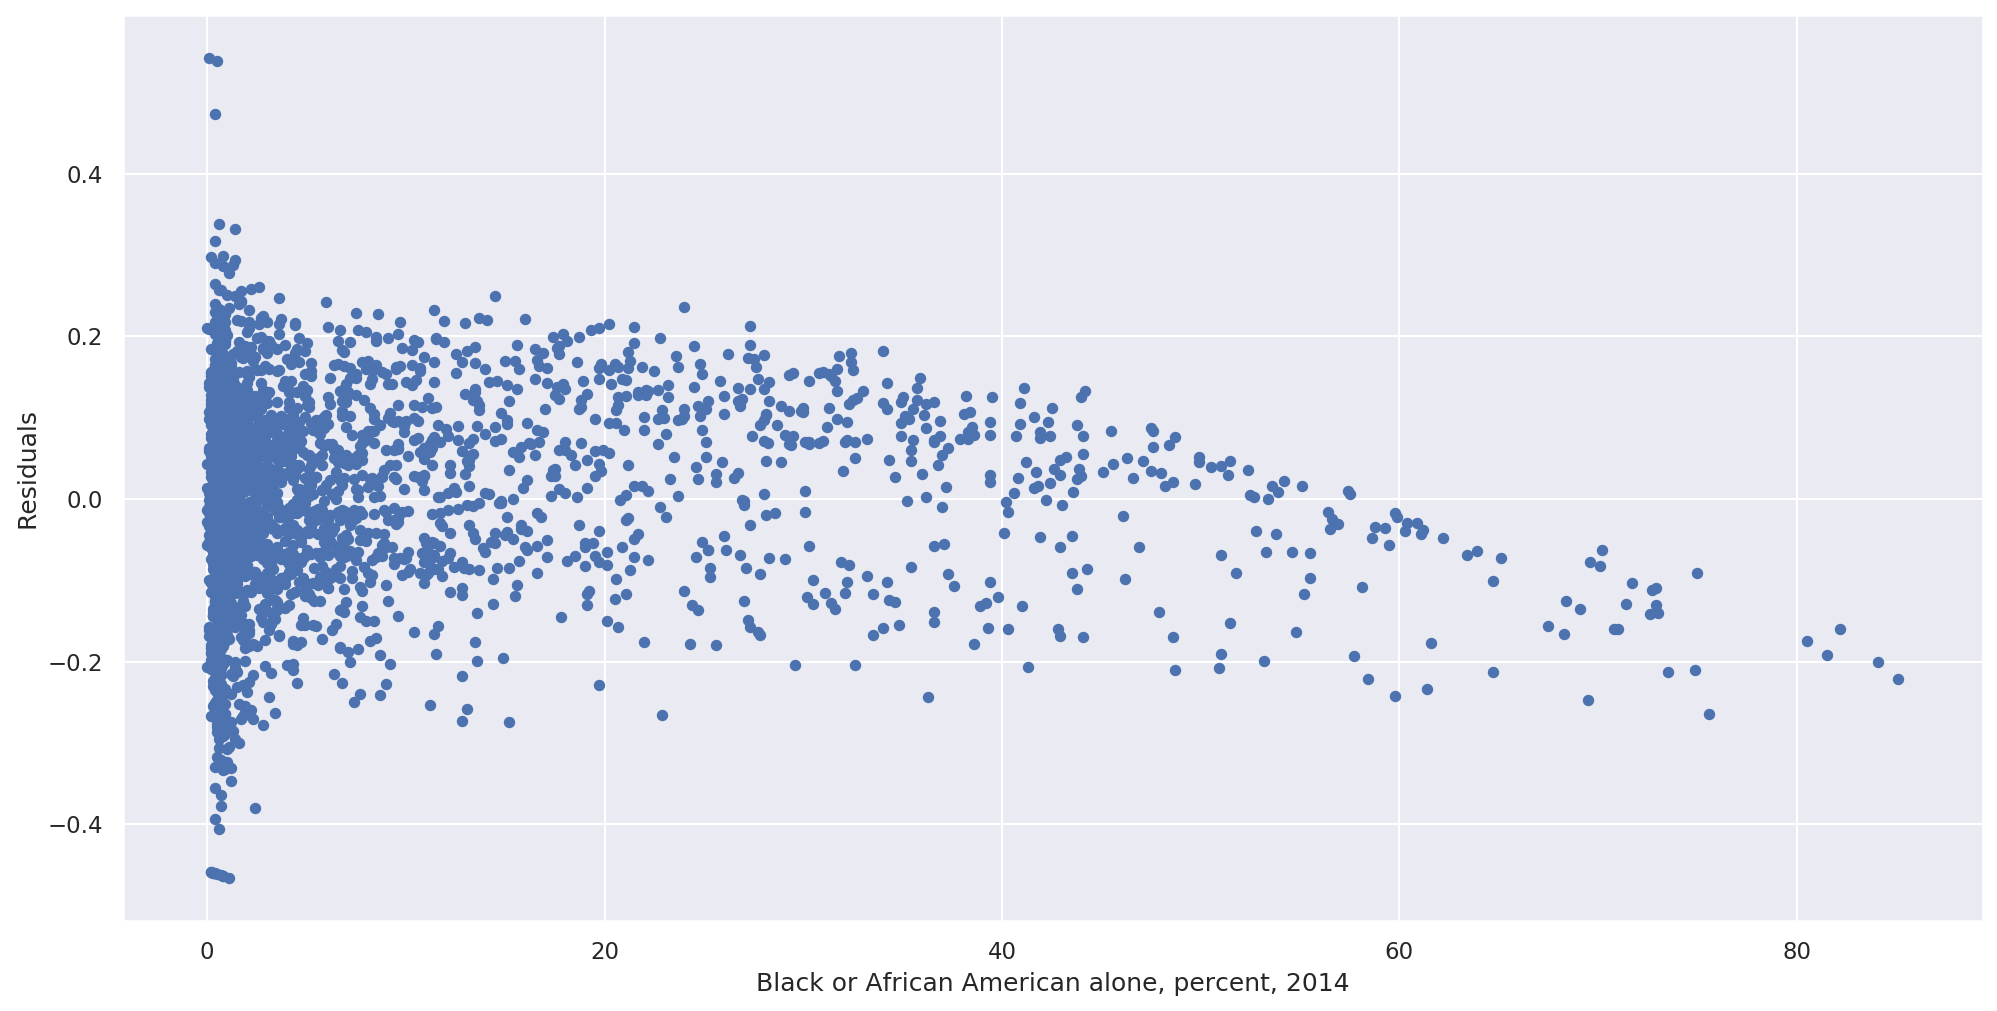

In [23]:
# YOUR CODE HERE
xval = np.asmatrix(df["Black or African American alone, percent, 2014"]).reshape(-1,1)
pred = model.predict(xval)
resid = df[["Hillary Clinton"]] - pred
df["Residuals"] = resid 
df.plot.scatter("Black or African American alone, percent, 2014", "Residuals")

Hopefully, this plot just looks like random noise. <span style="color:blue">Does it? If not, what are the patterns you see and why do you think they appear?</span>

YOUR EXPLANATION HERE

As the percentage of "Black or African American alone, percent, 2014" increases, the residuals actually trend downwards. This is saying that there seems to be an underprediction in counties with high values of "Black or African American alone, percent, 2014". This means that there are other variables that contribute to this linear relationship.

### 1.4. MSE Breakdown

Another common metric used for evaluating linear models is the **mean squared error** or MSE. This is just the average of all the squared errors: 
$$MSE := \frac{1}{n}\sum_{i=1}^n \left(y_i-\hat y_i\right)^2$$

Note that you can compute this by taking the average of the squares of the residuals.

First, find the MSE of your linear model on the whole dataset.

In [24]:
# YOUR CODE HERE
x= np.mean((resid)**2)
mse = x[0]
mse


0.01407807540289543

Now, we want to see if our model is doing better or worse on different parts of our dataset. Pick a categorical variable $z$ in the dataset that you think is related to $y$. If you don't have any categorical variables you think are relevant, then you could pick some quantitative variable (other than $x$ and $y$) and split your data up into "categories" based on whether or not that variable is greater than its mean - for example, doing separate regressions on counties which voted more than average or less than average for Sanders. In this case, make sure you add an indicator variable column to your dataframe - I'll refer to this column as $z$.

After selecting $z$, find the MSE for each possible value of $z$, i.e. for each possible category of your data. To do this, find the average squared residual in each category.

In [33]:
# YOUR CODE HERE
mean = np.mean(df["Donald Trump"])
df["Categorical"] = df['Donald Trump'] // mean

xval1 = np.asmatrix(df[df['Categorical'] == 1]["Black or African American alone, percent, 2014"]).reshape(-1,1)
pred1 = model.predict(xval1)
resid1 = df[df["Categorical"] == 1][["Hillary Clinton"]] - pred1

xval2 = np.asmatrix(df[df['Categorical'] == 0]["Black or African American alone, percent, 2014"]).reshape(-1,1)
pred2 = model.predict(xval2)
resid2 = df[df["Categorical"] == 0][["Hillary Clinton"]] -pred2

mse1 = np.mean((resid1)**2)[0]
mse2 = np.mean((resid2)**2)[0]
print(mse1,mse2)
            

0.012393227907852817 0.015069047601255643


Are some categories much better or worse than others? Why do you think this might be the case? To answer this, feel free to poke around a little bit more in your data - for example, you could try making plots of $x$ vs $y$ in each category.

YOUR RESPONSE HERE

The model works better for some categories than others. There are so many variables, like poopulation for example, that can work better as the size of a population or what the percentage of a certain demographic present in that said population can give us a lot of information. This can be attributed by sample size, having larger sample sizes mean less variability.

## 2. Submission

**To submit, first save this file as a pdf by going to the top left and clicking File -> Download as -> PDF via LaTex (.pdf), then fill out this form!**

https://docs.google.com/forms/d/e/1FAIpQLSfjI4yuukEC60rfOYPsJ7r1W0u4Kwjpr8pVxXL1qpqXu4hq0w/viewform